## ６章　ゲート付きRNN 

### 6.1 RNNの問題点

5章で作成したRNNは、時系列データの長期の依存関係を学習することが苦手です。

その理由として、BPTT(backpropagation through time)において勾配消失、勾配爆発が起こることが原因があります。

具体的に、次の文章を考えてみたいと思います。

![](../pictures/pict6-1.png)

答えは「Tom」です。RNNLMが正しく答えるには、

「Tomが部屋でテレビを見ていること」
「その部屋にMaryが入ってきたこと」

を記憶しておく必要があります。

つまり、その情報をRNNレイヤの隠れ状態にエンコードして保持しておく必要があります。

「Tom」を正解ラベルとして、勾配はどのように伝播するのか見てみます。

![](../pictures/pict6-2.png)

このシンプルなRNNレイヤでは、時間を遡るの従って勾配が小さくなるか、大きくなるのどちらかになってしまうのがほとんど。

### 6.2 勾配消失もしくは勾配爆発の原因

時間方向だけの勾配の伝播だけに着目してみます。

![](../pictures/pict6-3.png)

ここでは、長さTの時系列データを考え、T番目の正解ラベルから伝わる勾配がどのように変化するかに注視します。

通過する演算は、「tanh」「MatmMul」「+」の３つです。それぞれ見ていきます。

>「+」演算子

上流からの勾配をそのまま流すだけなので、値は変化しません。

>「tanh」演算子

tanhの定義は
$$
f(x) = \text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$
これを微分すると
$$
f'(x) = 1 - {f(x)}^{2}
$$
となります。

![](../pictures/pict6-4.png)

この図からもわかるように、微分係数の最大が１で、逆伝播において勾配がtanhを通るたびに、値が小さくなってしまいます。

tanhをT回通過すれば、勾配はT回も弱められることになります。

>「MatMul」演算子

![](../pictures/pict6-5.png)

MatMulレイヤのみに注目して、逆伝播を見てみましょう。

MatMulレイヤを通るたびに、Whが使われています。つまり、同じ重みが使われています。

では、勾配の値はどのように変化するのでしょうか。

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


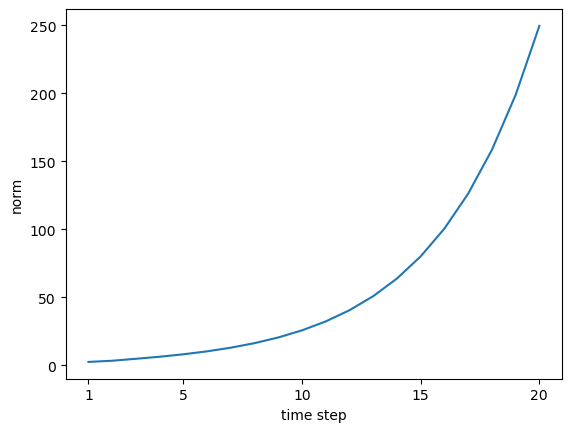

In [3]:
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T): # 20回繰り返す
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


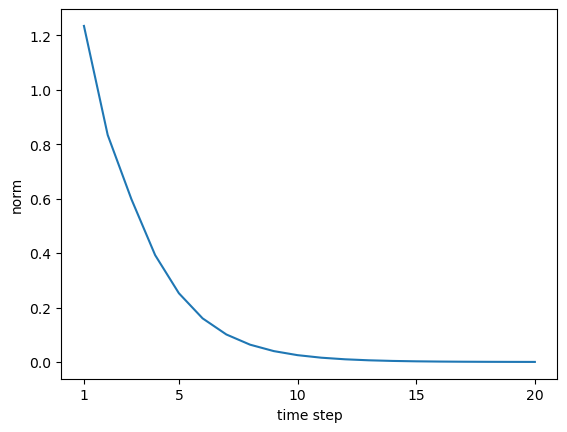

In [7]:
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T): # 20回繰り返す
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配の大きさは指数的に増加、減少しました。理由はWhをT回乗算しているからです。

Whの特異値の最大値が１より大きいかどうかで、勾配の大きさの変化を予測できます。

### 6.3　勾配爆発への対策


**勾配クリッピング**

$$
\text{if} \quad ||\hat{g}|| \geq \text{threshold} :
$$

$$
\hat{g} = \frac{\text{threshold}}{||\hat{g}||} \hat{g}
$$



ここでｇハットはNNで使われる全てのパラメータに対する勾配を一つにまとめていることを想定しています。

In [9]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:  
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [9.75995422 6.72383676 9.02834109 8.45750871 3.77994041 0.92217009
 6.53410903 5.57840762 3.61564763]
after: [2.00518189 1.38141178 1.85487202 1.73759455 0.77658848 0.18945978
 1.34243223 1.14608344 0.74283454]


### 6.4 勾配消失とLSTM

勾配消失を解消するには根本的にアーキテクチャを変えなければいけません。

そこで登場するのが、LSTM（Long Short Term Memory）です。

![](../pictures/pict6-6.png)

RNNレイヤとの違いは、ｃという経路があることです。

このｃは***記憶セル***と呼ばれ、LSTM専用の記憶部に相当します。

特徴としては、LSTMレイヤ内だけで情報を受け渡しをします。

つまり、**LSTM内だけで完結し、他のレイヤへは出力しません**

LSTMレイヤの中身を見ていきます。

![](../pictures/pict6-7.png)

この構造を元に、以降様々なゲートを加えていき、LSTMを完成させます。

※ゲートとは

![](../pictures/pict6-8.png)

どれだけゲートを開けるか、もデータから自動的に学ばせます。開き具合を求めるにあたっては、sigmoid関数を使用します。

### 6.5 outputゲート

tanh(Ct)に対してゲートを適用します。つまり、tanh(Ct)の各要素に対して、

「それらが次時刻の隠れ状態としてどれだけ重要か」ということを調整します。

このゲートを次の隠れ状態の出力を司るゲートであることから、**outputゲート**と呼ばれます。行う計算は次のようになります。

$$
\mathbf{o} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(o)} + \mathbf{b}^{(o)})
$$


![](../pictures/pict6-9.png)

ここでの「o」と「tanh(Ct)」の積はアダマール積（要素ごとの積）になります。

以上がoutputゲートです。

### 6.6 forgetゲート

記憶セルに対して、「何を忘れるか」をゲートで表現します。

C_t-1の記憶から、不要な記憶を忘れるためのゲートを追加します。これをforgetゲートと呼びます。

![](../pictures/pict6-10.png)

行う計算は次の式です。
$$
\mathbf{f} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(f)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(f)} + \mathbf{b}^{(f)})
$$


### 6.7 新しい記憶セル

forgetゲートによって全時刻の記憶セルから忘れられるべきものが削除されました。

しかし、これでは記憶セルは忘れることしかできません。そこで新しく覚えるべき情報を記憶セルに追加します。

![](../pictures/pict6-11.png)